In [20]:
import warnings
warnings.filterwarnings('ignore') 

from adversarial_models import * 
from utils import *
from get_data import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

import lime
import lime.lime_tabular
import shap
from copy import deepcopy

In [21]:
# fraction = 0.01
# frac_normal = 0.3

# req_cols = [' Init_Win_bytes_backward',
#                         ' Destination Port',' Fwd Packet Length Std',
#                         ' Flow IAT Max','Total Length of Fwd Packets',' Flow Duration', ' Label']

# cols = req_cols
# df0 = pd.read_csv ('cicids_db/Wednesday-workingHours.pcap_ISCX.csv', usecols=req_cols)
# df1 = pd.read_csv ('cicids_db/Tuesday-WorkingHours.pcap_ISCX.csv', usecols=req_cols)
# df2 = pd.read_csv ('cicids_db/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', usecols=req_cols)
# df3 = pd.read_csv ('cicids_db/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', usecols=req_cols)
# df4 = pd.read_csv ('cicids_db/Monday-WorkingHours.pcap_ISCX.csv', usecols=req_cols)
# df5 = pd.read_csv ('cicids_db/Friday-WorkingHours-Morning.pcap_ISCX.csv', usecols=req_cols)
# df6 = pd.read_csv ('cicids_db/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', usecols=req_cols)
# df7 = pd.read_csv ('cicids_db/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', usecols=req_cols)

# frames = [df0, df1, df2, df3, df4, df5,df6, df7]

# df = pd.concat(frames,ignore_index=True)
# df = df.sample(frac = fraction)

# y = df.pop(' Label')
# df = df.assign(Label = y)

# print('reached')

# print('---------------------------------------------------------------------------------')
# print('Reducing Normal rows')
# print('---------------------------------------------------------------------------------')
# print('')


# #filters

# filtered_normal = df[df['Label'] == 'BENIGN']

# #reduce

# reduced_normal = filtered_normal.sample(frac=frac_normal)

# #join

# df = pd.concat([df[df['Label'] != 'BENIGN'], reduced_normal])

# ''' ---------------------------------------------------------------'''
# df_max_scaled = df.copy()


# y = df_max_scaled['Label'].replace({'DoS GoldenEye': 'Dos/Ddos', 'DoS Hulk': 'Dos/Ddos', 'DoS Slowhttptest': 'Dos/Ddos', 'DoS slowloris': 'Dos/Ddos', 'Heartbleed': 'Dos/Ddos', 'DDoS': 'Dos/Ddos','FTP-Patator': 'Brute Force', 'SSH-Patator': 'Brute Force','Web Attack - Brute Force': 'Web Attack', 'Web Attack - Sql Injection': 'Web Attack', 'Web Attack - XSS': 'Web Attack'})

# df_max_scaled.pop('Label')

# print('reached2')

# df = df.assign(Label = y)


# X = df
# y = X['Label']

# y,label = pd.factorize(y)
# y = pd.DataFrame(y)
# label = list(label)

# df ['Label'] = y 
# X = X.drop(["Label"], axis=1)
# print(label.index('BENIGN'))
# X[' Flow Duration'] = [label.index('BENIGN') if v > 10000 else label.index('Dos/Ddos')  for v in X[' Flow Duration'].values]

# # y = np.array([POSITIVE_OUTCOME if p == 0 else NEGATIVE_OUTCOME for p in y.values])
# # y = np.array([POSITIVE_OUTCOME if p == 1 else NEGATIVE_OUTCOME for p in y.values])

In [22]:
# Get the data set and do some preprocessing
# cols = [' Init_Win_bytes_backward',
#         ' Destination Port',' Fwd Packet Length Std',
#         ' Flow IAT Max','Total Length of Fwd Packets']

# X = df[cols]  # Select the features from df
# y = df[' Label']  # Replace 'target_column' with the actual name of your target column

params = Params("model_configurations/experiment_params.json")
np.random.seed(params.seed)
X, y, cols = get_and_preprocess_cicids(params)

# Add a random column -- this is what we'll have LIME/SHAP explain.
X['unrelated_column'] = np.random.choice([0,1],size=X.shape[0])
features = [c for c in X]

categorical_feature_name = [' Init_Win_bytes_backward',
                            ' Destination Port',' Fwd Packet Length Std',
                            ' Flow IAT Max','Total Length of Fwd Packets', 
                            'unrelated_column']

categorical_feature_indcs = [features.index(c) for c in categorical_feature_name]

race_indc = features.index(' Flow Duration')
unrelated_indcs = features.index('unrelated_column')
X = X.values

---------------------------------------------------------------------------------
Reducing Normal rows
---------------------------------------------------------------------------------

['PortScan', 'Dos/Ddos', 'Brute Force', 'Web Attack', 'Bot', 'BENIGN']
5


In [23]:
class racist_model_f:
    # Decision rule: classify negatively if race is black
    def predict(self,X):
        return np.array([params.negative_outcome if x[race_indc] > 0 else params.positive_outcome for x in X])

    def predict_proba(self, X): 
        return one_hot_encode(self.predict(X))

    def score(self, X,y):
        return np.sum(self.predict(X)==y) / len(X)
    
class innocuous_model_psi:
    # Decision rule: classify according to randomly drawn column 'unrelated column'
    def predict(self,X):
        return np.array([params.negative_outcome if x[unrelated_indcs] > 0 else params.positive_outcome for x in X])

    def predict_proba(self, X): 
        return one_hot_encode(self.predict(X))

    def score(self, X,y):
        return np.sum(self.predict(X)==y) / len(X)

In [24]:
# Split the data and normalize
xtrain,xtest,ytrain,ytest = train_test_split(X,y)
xtest_not_normalized = deepcopy(xtest)
ss = StandardScaler().fit(xtrain)
xtrain = ss.transform(xtrain)
xtest = ss.transform(xtest)

# Train the adversarial model for LIME with f and psi 
adv_lime = Adversarial_Lime_Model(racist_model_f(), innocuous_model_psi()).\
            train(xtrain, ytrain, feature_names=features, categorical_features=categorical_feature_indcs)

In [25]:
# Let's just look at a the first example in the test set
ex_indc = np.random.choice(xtest.shape[0])
# print(xtest.shape[0])
indices = np.where(ytest == 1)
index_positions = indices[0]
# print(index_positions)
ex_indc = index_positions[0]
# To get a baseline, we'll look at LIME applied to the biased model f
normal_explainer = lime.lime_tabular.LimeTabularExplainer(xtrain,feature_names=adv_lime.get_column_names(),
                                                          discretize_continuous=False,
                                                          categorical_features=categorical_feature_indcs)

normal_exp = normal_explainer.explain_instance(xtest[ex_indc], racist_model_f().predict_proba).as_list()

print('------------------------------------------------------------------')
print('real value', ytest[ex_indc:ex_indc+1])
# print(ytest)
print('------------------------------------------------------------------')
print('------------------------------------------------------------------')
# print(xtest[ex_indc])
# print(xtest)
print('predicted value', racist_model_f().predict(xtest)[ex_indc])

print('------------------------------------------------------------------')


# pred = racist_model_f().predict_proba(xtest[ex_indc])                             
# print('prediction', pred)
print ("Explanation on biased f:\n",normal_exp[:3],"\n\n")

# Now, lets look at the explanations on the adversarial model 
adv_explainer = lime.lime_tabular.LimeTabularExplainer(xtrain,feature_names=adv_lime.get_column_names(), 
                                                       discretize_continuous=False,
                                                       categorical_features=categorical_feature_indcs)

adv_exp = adv_explainer.explain_instance(xtest[ex_indc], adv_lime.predict_proba).as_list()

print ("Explanation on adversarial model:\n",adv_exp[:3],"\n")

print("Prediction fidelity: {0:3.2}".format(adv_lime.fidelity(xtest[ex_indc:ex_indc+1])))

------------------------------------------------------------------
real value [1]
------------------------------------------------------------------
------------------------------------------------------------------
predicted value 0
------------------------------------------------------------------
Explanation on biased f:
 [(' Flow Duration', -0.42936574237870545), (' Init_Win_bytes_backward=0', 0.031175140024487742), (' Flow IAT Max=0', 0.01703016877669859)] 


Explanation on adversarial model:
 [('unrelated_column=0', -0.9978353238266603), (' Fwd Packet Length Std=0', 0.0002532979710998189), (' Flow IAT Max=0', -0.0002405386708101747)] 

Prediction fidelity: 1.0


### LIME Results
What we have is the top three features of the explanation on the biased model followed by the explanation on that same instance using the adversarial model. We see that the top feature is now the randomly drawn column, indicating that the attack was able to fool LIME. We also see that the adversarial model predicts this instance _the same_ as the biased model (fidelity=1)—although the model predicts the same results, its reasoning has changed.

Next, let's look at the SHAP adversarial model.  We'll go through a similar process as above except using SHAP.

In [26]:
# Train the adversarial model
adv_shap = Adversarial_Kernel_SHAP_Model(racist_model_f(), innocuous_model_psi()).\
            train(xtrain, ytrain, feature_names=features)

100%|██████████| 1/1 [00:00<00:00, 35.93it/s]


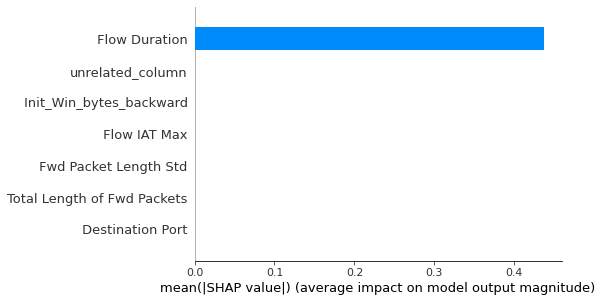

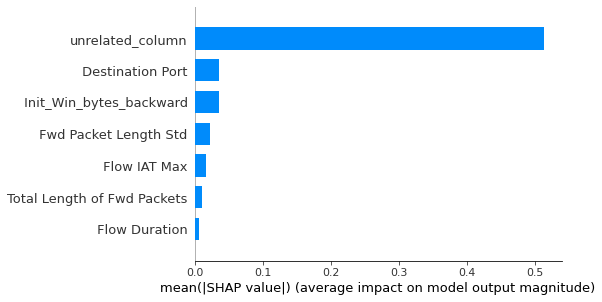

Fidelity: 1.0


In [27]:
# Set the background distribution for the shap explainer using kmeans
background_distribution = shap.kmeans(xtrain,10)

# Let's use the shap kernel explainer and grab a point to explain
to_examine = np.random.choice(xtest.shape[0])

# Explain the biased model
biased_kernel_explainer = shap.KernelExplainer(racist_model_f().predict, background_distribution)
biased_shap_values = biased_kernel_explainer.shap_values(xtest[to_examine:to_examine+1])

# Explain the adversarial model
adv_kerenel_explainer = shap.KernelExplainer(adv_shap.predict, background_distribution)
adv_shap_values = adv_kerenel_explainer.shap_values(xtest[to_examine:to_examine+1])

# Plot it using SHAP's plotting features.
shap.summary_plot(biased_shap_values, feature_names=features, plot_type="bar")
shap.summary_plot(adv_shap_values, feature_names=features, plot_type="bar")

print ("Fidelity: {0:3.2}".format(adv_shap.fidelity(xtest[to_examine:to_examine+1])))

In [28]:
xtest.shape[0]

3096

In [29]:
# 4 buckets, 3 graphs
dict_biased_1 = {
    'Biased': 0,
    'Unrelated_1':0,
    'Unrelated_2':0,
    'Others':0
}
dict_biased_2 = {
    'Biased': 0,
    'Unrelated_1':0,
    'Unrelated_2':0,
    'Others':0
}
dict_biased_3 = {
    'Biased': 0,
    'Unrelated_1':0,
    'Unrelated_2':0,
    'Others':0
}
attack_1 = {
    'Biased': 0,
    'Unrelated_1':0,
    'Unrelated_2':0,
    'Others':0
}

attack_2 = {
    'Biased': 0,
    'Unrelated_1':0,
    'Unrelated_2':0,
    'Others':0
}

attack_3 = {
    'Biased': 0,
    'Unrelated_1':0,
    'Unrelated_2':0,
    'Others':0
}


In [30]:
# features analyzed
biased_feature = ' Flow Duration'
Unrelated_1_feature = 'unrelated_column'
# Unrelated_2_feature = 'unrelated_column'
samples = 1000

In [31]:
for i in range(0,samples):   
 # Set the background distribution for the shap explainer using kmeans
    background_distribution = shap.kmeans(xtrain,10)

    # Let's use the shap kernel explainer and grab a point to explain
    to_examine = i

    # to_examine = np.random.choice(xtest.shape[0])

    # Explain the biased model
    biased_kernel_explainer = shap.KernelExplainer(racist_model_f().predict, background_distribution)
    biased_shap_values = biased_kernel_explainer.shap_values(xtest[to_examine:to_examine+1])

    # print(biased_kernel_explainer)

    # Explain the adversarial model
    adv_kerenel_explainer = shap.KernelExplainer(adv_shap.predict, background_distribution)
    adv_shap_values = adv_kerenel_explainer.shap_values(xtest[to_examine:to_examine+1])

    # Plot it using SHAP's plotting features.
    # shap.summary_plot(biased_shap_values, feature_names=features, plot_type="bar")
    # shap.summary_plot(adv_shap_values, feature_names=features, plot_type="bar")

    # print(adv_shap_values)
    # print(features)

    biased_df = pd.DataFrame({
            'shap_values': biased_shap_values[0],
            'shap_values_abs': abs(biased_shap_values[0]),
            'features': features    
        })
    attack1_df = pd.DataFrame({
            'shap_values': adv_shap_values[0],
            'shap_values_abs':abs(adv_shap_values[0]),
            'features': features    
        })
    # info = [adv_shap_values,features]

    attack1_df.sort_values(by=['shap_values_abs'], ascending=False,inplace=True)
    biased_df.sort_values(by=['shap_values_abs'], ascending=False,inplace=True)

    attack1_df = attack1_df.reset_index(drop=True)
    biased_df = biased_df.reset_index(drop=True)

    # print('Attack')
    # print('------------------------------')
    # print (attack1_df)
    # print('Biased')
    # print('------------------------------')
    # print(biased_df)


    #biased columns

    #For 1st position
    if biased_df['features'][0] == biased_feature: dict_biased_1['Biased'] = dict_biased_1['Biased'] + 1
    elif biased_df['features'][0] == Unrelated_1_feature: dict_biased_1['Unrelated_1'] = dict_biased_1['Unrelated_1'] + 1
    # elif biased_df['features'][0] == Unrelated_2_feature: dict_biased_1['Unrelated_2'] = dict_biased_1['Unrelated_2'] + 1
    else: dict_biased_1['Others'] = dict_biased_1['Others'] + 1

    #For 2st position
    if biased_df['features'][1] == biased_feature: dict_biased_2['Biased'] = dict_biased_2['Biased'] + 1
    elif biased_df['features'][1] == Unrelated_1_feature: dict_biased_2['Unrelated_1'] = dict_biased_2['Unrelated_1'] + 1
    # elif biased_df['features'][1] == Unrelated_2_feature: dict_biased_2['Unrelated_2'] = dict_biased_2['Unrelated_2'] + 1
    else: dict_biased_2['Others'] = dict_biased_2['Others'] + 1

    #For 3st position
    if biased_df['features'][2] == biased_feature: dict_biased_3['Biased'] = dict_biased_3['Biased'] + 1
    elif biased_df['features'][2] == Unrelated_1_feature: dict_biased_3['Unrelated_1'] = dict_biased_3['Unrelated_1'] + 1
    # elif biased_df['features'][2] == Unrelated_2_feature: dict_biased_3['Unrelated_2'] = dict_biased_3['Unrelated_2'] + 1
    else: dict_biased_3['Others'] = dict_biased_3['Others'] + 1


    #Attack 1 columns

    #For 1st position
    if attack1_df['features'][0] == biased_feature: attack_1['Biased'] = attack_1['Biased'] + 1
    elif attack1_df['features'][0] == Unrelated_1_feature: attack_1['Unrelated_1'] = attack_1['Unrelated_1'] + 1
    # elif attack1_df['features'][0] == Unrelated_2_feature: attack_1['Unrelated_2'] = attack_1['Unrelated_2'] + 1
    else: attack_1['Others'] = attack_1['Others'] + 1

    #For 2st position
    if attack1_df['features'][1] == biased_feature: attack_2['Biased'] = attack_2['Biased'] + 1
    elif attack1_df['features'][1] == Unrelated_1_feature: attack_2['Unrelated_1'] = attack_2['Unrelated_1'] + 1
    # elif attack1_df['features'][1] == Unrelated_2_feature: attack_2['Unrelated_2'] = attack_2['Unrelated_2'] + 1
    else: attack_2['Others'] = attack_2['Others'] + 1

    #For 3st position
    if attack1_df['features'][2] == biased_feature: attack_3['Biased'] = attack_3['Biased'] + 1
    elif attack1_df['features'][2] == Unrelated_1_feature: attack_3['Unrelated_1'] = attack_3['Unrelated_1'] + 1
    # elif attack1_df['features'][2] == Unrelated_2_feature: attack_3['Unrelated_2'] = attack_3['Unrelated_2'] + 1
    else: attack_3['Others'] = attack_3['Others'] + 1


# print ("Fidelity: {0:3.2}".format(adv_shap.fidelity(xtest[to_examine:to_examine+1])))

100%|██████████| 1/1 [00:00<00:00, 26.19it/s]


In [32]:
#Normalized
keys = ['Biased','Unrelated_1','Unrelated_2','Others' ]
for x in keys:

    dict_biased_1[x] = dict_biased_1[x]/samples
    dict_biased_2[x] = dict_biased_2[x]/samples
    dict_biased_3[x] = dict_biased_3[x]/samples

    attack_1[x] = attack_1[x]/samples
    attack_2[x] = attack_2[x]/samples
    attack_3[x] = attack_3[x]/samples

In [33]:
print(dict_biased_1 )
print(dict_biased_2 )
print(dict_biased_3 )
print('--------------')
print(attack_1 )
print(attack_2 )
print(attack_3 )

{'Biased': 1.0, 'Unrelated_1': 0.0, 'Unrelated_2': 0.0, 'Others': 0.0}
{'Biased': 0.0, 'Unrelated_1': 0.0, 'Unrelated_2': 0.0, 'Others': 1.0}
{'Biased': 0.0, 'Unrelated_1': 0.0, 'Unrelated_2': 0.0, 'Others': 1.0}
--------------
{'Biased': 0.0, 'Unrelated_1': 0.99, 'Unrelated_2': 0.0, 'Others': 0.01}
{'Biased': 0.1, 'Unrelated_1': 0.01, 'Unrelated_2': 0.0, 'Others': 0.89}
{'Biased': 0.07, 'Unrelated_1': 0.0, 'Unrelated_2': 0.0, 'Others': 0.93}


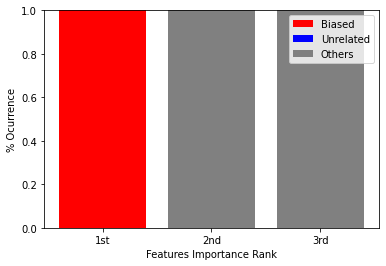

In [38]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
total = samples 
# create data
x = ['1st', '2nd', '3rd']
y1 = np.array([dict_biased_1['Biased'], dict_biased_2['Biased'], dict_biased_3['Biased']])
y2 = np.array([dict_biased_1['Unrelated_1'], dict_biased_2['Unrelated_1'], dict_biased_3['Unrelated_1']])
y3 = np.array([dict_biased_1['Others'], dict_biased_2['Others'], dict_biased_3['Others']])
y4 = np.array([dict_biased_1['Unrelated_2'], dict_biased_2['Unrelated_2'],dict_biased_3['Unrelated_2']])


# plot bars in stack manner
plt.bar(x, y1, color='r')
plt.bar(x, y2, bottom=y1, color='b')
plt.bar(x, y3, bottom=y1+y2, color='grey')
# plt.bar(x, y4, bottom=y1+y2+y3, color='g')
plt.xlabel("Features Importance Rank")
plt.ylabel("% Ocurrence")
# plt.legend(["Biased", "Unrelated", "Unrelated_2", "Others"])
plt.legend(["Biased", "Unrelated", "Others"])

plt.show()


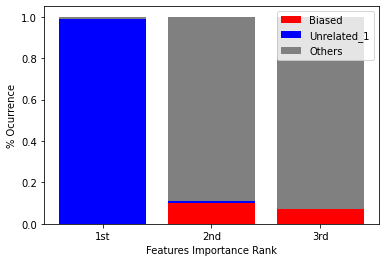

In [39]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
total = samples 
# create data
x = ['1st', '2nd', '3rd']
y1 = np.array([attack_1['Biased'], attack_2['Biased'], attack_3['Biased']])
y2 = np.array([attack_1['Unrelated_1'], attack_2['Unrelated_1'], attack_3['Unrelated_1']])
y3 = np.array([attack_1['Others'], attack_2['Others'],attack_3['Others']])
# y4 = np.array([attack_1['Unrelated_2'], attack_2['Unrelated_2'], attack_3['Unrelated_2']])

# plot bars in stack manner
plt.bar(x, y1, color='r')
plt.bar(x, y2, bottom=y1, color='b')
plt.bar(x, y3, bottom=y1+y2, color='grey')
# plt.bar(x, y4, bottom=y1+y2+y3, color='g')
plt.xlabel("Features Importance Rank")
plt.ylabel("% Ocurrence")
# plt.legend(["Biased", "Unrelated_1", "Unrelated_2", "Others"])
plt.legend(["Biased", "Unrelated_1", "Others"])

plt.show()
